In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import catboost as cb
from catboost import CatBoostClassifier
from scipy.stats import ttest_ind

### Part 1 - Exploratory Data Analysis

In [14]:
login = pd.read_json('logins.json')

In [10]:
login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [15]:
login['count'] = 1
login.set_index(login.login_time, inplace=True)
login = login.resample('15T').sum()

In [16]:
login.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


<Axes: xlabel='login_time'>

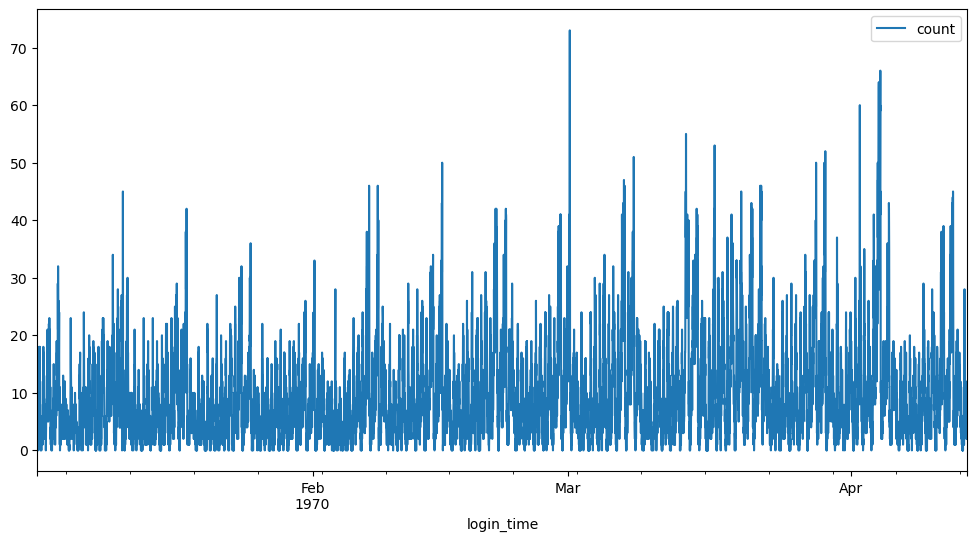

In [17]:
login.plot(kind='line',figsize=(12,6))

In [28]:
login['weeks'] = login.index.strftime('%A')

In [35]:
login.groupby('weeks').size().sort_values(ascending=False)

weeks
Friday       1440
Saturday     1440
Sunday       1440
Monday       1420
Thursday     1360
Tuesday      1344
Wednesday    1344
dtype: int64

Weekends are the busiest days.

Part 2 : Experiment and Metrics Design

## Part 3 - Predictive modeling

In [105]:
df = pd.read_json('ultimate_data_challenge.json')

In [38]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [39]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [106]:
# checking if the user is active by checking if the last trip date falls within 30 days after 6 months
for row in df.itertuples():
    tmp_signup = pd.Timestamp(row.signup_date)
    tmp_date = tmp_signup + pd.Timedelta('181D')
    tmp_pointer = tmp_date - pd.Timedelta('30D')
    if tmp_pointer <= pd.Timestamp(row.last_trip_date) <= tmp_date:
        df.loc[row.Index, 'active_user'] = 1
    else:
        df.loc[row.Index, 'active_user'] = 0
        
df.active_user = df.active_user.astype('uint8')

Find active users and percentage.

In [107]:
x = df.groupby('active_user').agg(total=('active_user','count')).reset_index()

In [108]:
active = x[x.active_user==1]['total'].squeeze()
inactive = x[x.active_user==0]['total'].squeeze()
percent = active/(active+inactive) * 100
print('Active users: {}, Active percentage: {}'.format(active, percent))

Active users: 12198, Active percentage: 24.396


Fill the missing values with mean for avg_rating_of_driver, and avg_rating_by_driver features.

In [109]:
df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(), inplace=True)
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(), inplace=True)

Let's look at the phone feature.

In [66]:
df.groupby('phone').size()

phone
Android    15022
iPhone     34582
dtype: int64

Looks like majority of people use iPhone. But, it could be considered that device has no impact on the business.

In [110]:
df.phone.fillna('Others', inplace=True)

In [111]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
active_user                 uint8
dtype: object

Convert the values of ultimate_black_user from bool to binary.

In [112]:
mapping = {True:1, False:0}
df.ultimate_black_user = df.ultimate_black_user.replace(mapping).astype('category')

In [124]:
df.corr()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active_user
trips_in_first_30_days,1.000000,-0.011060,-0.001841,0.005720,0.050388,-0.136329,-0.039097,0.204841
avg_rating_of_driver,-0.011060,1.000000,-0.021653,-0.003290,0.012587,0.028508,0.101660,-0.008363
avg_surge,-0.001841,-0.021653,1.000000,0.793582,-0.110071,-0.081491,0.010498,0.006267
surge_pct,0.005720,-0.003290,0.793582,1.000000,-0.144918,-0.104414,0.019964,0.017045
weekday_pct,0.050388,0.012587,-0.110071,-0.144918,1.000000,0.101652,0.020366,0.005518
avg_dist,-0.136329,0.028508,-0.081491,-0.104414,0.101652,1.000000,0.079793,-0.091802
avg_rating_by_driver,-0.039097,0.101660,0.010498,0.019964,0.020366,0.079793,1.000000,-0.022311
active_user,0.204841,-0.008363,0.006267,0.017045,0.005518,-0.091802,-0.022311,1.000000


In [113]:
X = df.iloc[:,:-1]
X.drop(['signup_date','last_trip_date'], axis=1,inplace=True)
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [114]:
# Define the categorical features
categorical_features_indices = [X.columns.get_loc(feature) for feature in categorical_features]

# Create the CatBoost Classifier
catboost_classifier = CatBoostClassifier(
    iterations=500,  # You can change this to any desired number of iterations
    learning_rate=0.1,  # You can change the learning rate as well
    depth=6,  # You can change the depth of the trees
    random_state=42,
    cat_features=categorical_features_indices
)

# Fit the classifier to the training data
catboost_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost_classifier.predict(X_test)

# Optionally, you can also obtain the predicted probabilities
y_pred_proba = catboost_classifier.predict_proba(X_test)

0:	learn: 0.6450848	total: 223ms	remaining: 1m 51s
1:	learn: 0.6060272	total: 266ms	remaining: 1m 6s
2:	learn: 0.5763061	total: 307ms	remaining: 50.9s
3:	learn: 0.5527126	total: 348ms	remaining: 43.1s
4:	learn: 0.5333432	total: 389ms	remaining: 38.5s
5:	learn: 0.5166888	total: 431ms	remaining: 35.5s
6:	learn: 0.5035200	total: 469ms	remaining: 33s
7:	learn: 0.4914231	total: 510ms	remaining: 31.4s
8:	learn: 0.4811508	total: 557ms	remaining: 30.4s
9:	learn: 0.4716277	total: 603ms	remaining: 29.6s
10:	learn: 0.4669662	total: 647ms	remaining: 28.8s
11:	learn: 0.4615992	total: 696ms	remaining: 28.3s
12:	learn: 0.4577826	total: 766ms	remaining: 28.7s
13:	learn: 0.4536671	total: 801ms	remaining: 27.8s
14:	learn: 0.4500239	total: 844ms	remaining: 27.3s
15:	learn: 0.4481890	total: 888ms	remaining: 26.8s
16:	learn: 0.4456422	total: 930ms	remaining: 26.4s
17:	learn: 0.4430343	total: 979ms	remaining: 26.2s
18:	learn: 0.4414179	total: 1.02s	remaining: 25.8s
19:	learn: 0.4399512	total: 1.06s	remainin

In [120]:
confusion_matrix(y_test, y_pred)

array([[6912,  622],
       [1391, 1075]], dtype=int64)

In [118]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.83      0.92      0.87      7534\n           1       0.63      0.44      0.52      2466\n\n    accuracy                           0.80     10000\n   macro avg       0.73      0.68      0.69     10000\nweighted avg       0.78      0.80      0.78     10000\n'

In [121]:
accuracy_score(y_test, y_pred)

0.7987

In [123]:
y_pred.shape

(10000,)

In [125]:
np.unique(y_pred, return_counts=True)

(array([0, 1], dtype=int64), array([8303, 1697], dtype=int64))

In [128]:
1697/(8303+1697) *100

16.97

Out of the 10,000 users 16.97% users will be active in the 6th month in the system.

Features that impacted most.

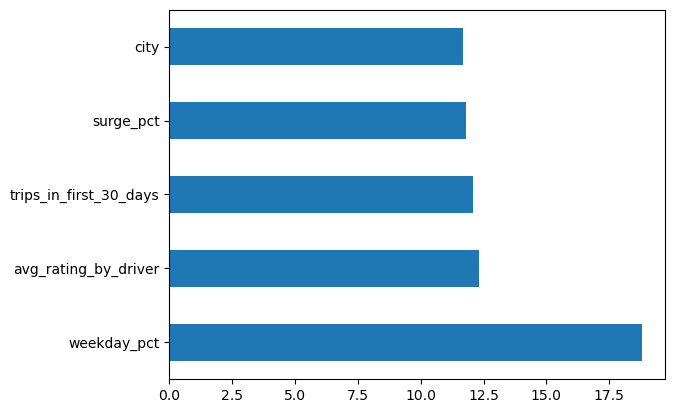

In [133]:
feat_importances = pd.Series(catboost_classifier.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [136]:
feat_importances.sort_values(ascending=False)

weekday_pct               18.794375
avg_rating_by_driver      12.301928
trips_in_first_30_days    12.087746
surge_pct                 11.796265
city                      11.685049
avg_dist                  10.010547
phone                      6.864662
avg_rating_of_driver       6.704496
avg_surge                  5.631534
ultimate_black_user        4.123398
dtype: float64

Let's do a t-test to determine if the company will be able to retain the 17% users on their 6th month.

Null-hypothesis: Users will not be retained.
Alternate-hypotheis: Users will be retained.

Set, significance level at 0.05.

In [138]:
# Split the dataset into two groups based on 'active_user'
active_users = df[df['active_user'] == 1]
inactive_users = df[df['active_user'] == 0]

# Extract the feature you want to compare (e.g., 'avg_rating_of_driver')
feature_to_compare = 'trips_in_first_30_days'

# Extract the feature values for each group
active_users_feature = active_users[feature_to_compare]
inactive_users_feature = inactive_users[feature_to_compare]

# Perform the independent two-sample t-test
t_statistic, p_value = ttest_ind(active_users_feature, inactive_users_feature, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 35.25305985940921
P-value: 2.293547144654168e-261


Since, p-value is less than 0.05, we can reject null-hypothesis and claim that users will be retained on their 6th month on the system.